#Подготовка датасета для ML (создание pipeline)

Импорты библиотек + подгружаем датасет из файла

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Dict, Optional, Union
from scipy.stats import iqr
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

# Загрузка данных - удалить при слиянии ноутбуков
# !поменять путь при загрузке в гит!
# df = pd.read_csv('../../data/train.csv')
df = pd.read_csv('train.csv')
df = df.drop(columns=['id'])

# Создаем копию данных для безопасного преобразования
df_processed = df.copy()

Разделяем признаки по категориям для удобства работы

In [100]:
# Все числовые признаки
numeric_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
                     'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

# Все категориальные признаки
categorical_features = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']

# Числовые признаки с асимметрией. Разделяем на 2 группы, т.к. нужны другие, более щадящие границы для 'Tryglicerides' и 'Cholesterol'
normal_skewed = ['Bilirubin', 'Copper', 'Alk_Phos', 'SGOT']
problem_skewed = ['Tryglicerides', 'Cholesterol']


# Числовые признаки симметричные
symmetric_features = ['N_Days', 'Age', 'Albumin', 'Platelets', 'Prothrombin']

# Автоматически разделяем категориальные признаки на бинарные и многоклассовые
binary_features = [col for col in categorical_features if df[col].nunique() == 2]
multi_category_features = [col for col in categorical_features if df[col].nunique() > 2]

##Обработка числовых признаков

###Задача 1. Работа с асимметриями

К признакам с выраженной асимметрией (по результатам EDA это: Bilirubin, Copper, Alk_Phos, SGOT, Triglycerides, Cholesterol) применяем логарифмическое преобразование. Для таких признаков выбросы часто являются естественной частью "длинного хвоста" распределения. Их "обрезка" может привести к потере важной информации. А вот логарифмическое преобразование в свою очередь:

*   Уменьшает асимметрию (скошенность).

*   Сжимает "длинный хвост", делая распределение более нормальным.

*   Ослабляет влияние выбросов на модель.

Создаем трансформер для логарифмирования признаков с асимметричным распределением

In [101]:
log_transformer = FunctionTransformer(
    func=np.log1p,
    feature_names_out="one-to-one"
)

###Задача 2. Работа с выбросами

Для выявления выбросов в признаках с относительно симметричным распределением было принято решение использовать методы, основанные на межквартильном размахе (IQR). Они менее чувствительны к умеренной асимметрии, чем методы, основанные на стандартном отклонении (z-score).
Для обработки выбросов было принято решение использовать clip.

Также пишем кастомный класс для дальнейшего создания pipeline (класс, а не функцию т.к. нужно запоминать границы)

In [102]:
class OutlierClipper(BaseEstimator, TransformerMixin):
    """
    Класс для обработки выбросов методом межквартильного размаха (IQR).

    Ограничивает значения признаков, выходящие за границы Q1 - 2.5*IQR и Q3 + 2.5*IQR.
    """
    def __init__(self, numeric_features: List[str], skip_features: Optional[List[str]] = None, iqr_multiplier: float = 2.5) -> None:
        """
        Инициализация класса
        """
        self.numeric_features = numeric_features
        self.skip_features = skip_features if skip_features is not None else []
        self.iqr_multiplier = iqr_multiplier
        self.clipping_bounds_: Dict[str, Tuple[float, float]] = {}

    def fit(self, X: Union[np.ndarray, pd.DataFrame], y: Optional[np.ndarray] = None) -> 'OutlierClipper':
        """
        Вычисляет границы clip для каждого признака на основе IQR.
        """
        if isinstance(X, pd.DataFrame):
            X_df = X[self.numeric_features]
        else:
            X_df = pd.DataFrame(X, columns=self.numeric_features)

        for col in self.numeric_features:
            if col in self.skip_features:
                continue

            Q1 = X_df[col].quantile(0.25)
            Q3 = X_df[col].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - self.iqr_multiplier * IQR
            upper_bound = Q3 + self.iqr_multiplier * IQR

            self.clipping_bounds_[col] = (lower_bound, upper_bound)

        return self

    def transform(self, X: Union[np.ndarray, pd.DataFrame]) -> Union[np.ndarray, pd.DataFrame]:
        """
        Применяет clip к данным, ограничивая выбросы вычисленными границами.
        """
    # Сохраняем тип данных
        input_is_dataframe = isinstance(X, pd.DataFrame)

        if input_is_dataframe:
            X_transformed = X.copy()
            index = X.index
            columns = X.columns
        else:
            X_transformed = X.copy()

        # Преобразуем в DataFrame для удобства работы
        if not input_is_dataframe:
            X_df = pd.DataFrame(X_transformed, columns=self.numeric_features)
        else:
            X_df = X_transformed[self.numeric_features]

        # Применяем clip
        for col, (lower_bound, upper_bound) in self.clipping_bounds_.items():
            X_df[col] = np.clip(X_df[col], lower_bound, upper_bound)

        # Возвращаем в исходном формате
        if input_is_dataframe:
            X_transformed[self.numeric_features] = X_df
            return X_transformed
        else:
            return X_df.values

    def get_feature_names_out(self, input_features=None) -> List[str]:
        """
        Возвращает имена признаков после преобразования.
        """
        if input_features is None:
            return self.numeric_features
        return input_features

    def set_output(self, transform: Optional[str] = None) -> 'OutlierClipper':
        """
        Настраивает формат вывода для метода transform.
        """
        self._output = transform
        return self

#Обработка категориальных признаков + Создание пайплайна

По результатам EDA бинарные признаки было принято решение кодировать  через OrdinalEncoder (0/1).

Для удобства дальнейшей работы создаем пайплайн.

In [103]:
# Создаем трансформеры
binary_transformer = OrdinalEncoder()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)
skewed_clipper_normal = OutlierClipper(normal_skewed, iqr_multiplier=2.0)
skewed_clipper_problem = OutlierClipper(problem_skewed, iqr_multiplier=3.0)
symmetric_clipper = OutlierClipper(symmetric_features, iqr_multiplier=1.5)

preprocessor = ColumnTransformer([
    ('skewed_normal', Pipeline([
        ('log', FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
        ('clip', skewed_clipper_normal),
        ('scale', RobustScaler())
    ]), normal_skewed),

    ('skewed_problem', Pipeline([
        ('log', FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
        ('clip', skewed_clipper_problem),
        ('scale', RobustScaler())
    ]), problem_skewed),

    ('symmetric', Pipeline([
        ('clip', symmetric_clipper),
        ('scale', RobustScaler())
    ]), symmetric_features),

    ('binary', OrdinalEncoder(), binary_features),
    ('categorical', OneHotEncoder(drop='first', sparse_output=False), multi_category_features)
],
verbose_feature_names_out=False
)

Готовим данные train для ML-модели

In [104]:
# Выделяем целевую переменную
X = df_processed[numeric_features + binary_features + multi_category_features]
y = df_processed['Status']

# Разделяем данные до преобразования
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Обучаем препроцессор на тренировочной части
preprocessor.fit(X_train)

# Применяем преобразования к обоим наборам
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Создаем DataFrame
feature_names = preprocessor.get_feature_names_out()
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

print(f"Train: {X_train_processed_df.shape}")
print(f"Test:  {X_test_processed_df.shape}")

Train: (6324, 21)
Test:  (1581, 21)


#Визуализация результатов

1. Сравнение асимметрий ДО/ПОСЛЕ

=== СРАВНЕНИЕ ПРИЗНАКОВ С АСИММЕТРИЕЙ ===
Сравниваем 6 skewed-признаков: ['Bilirubin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Cholesterol']


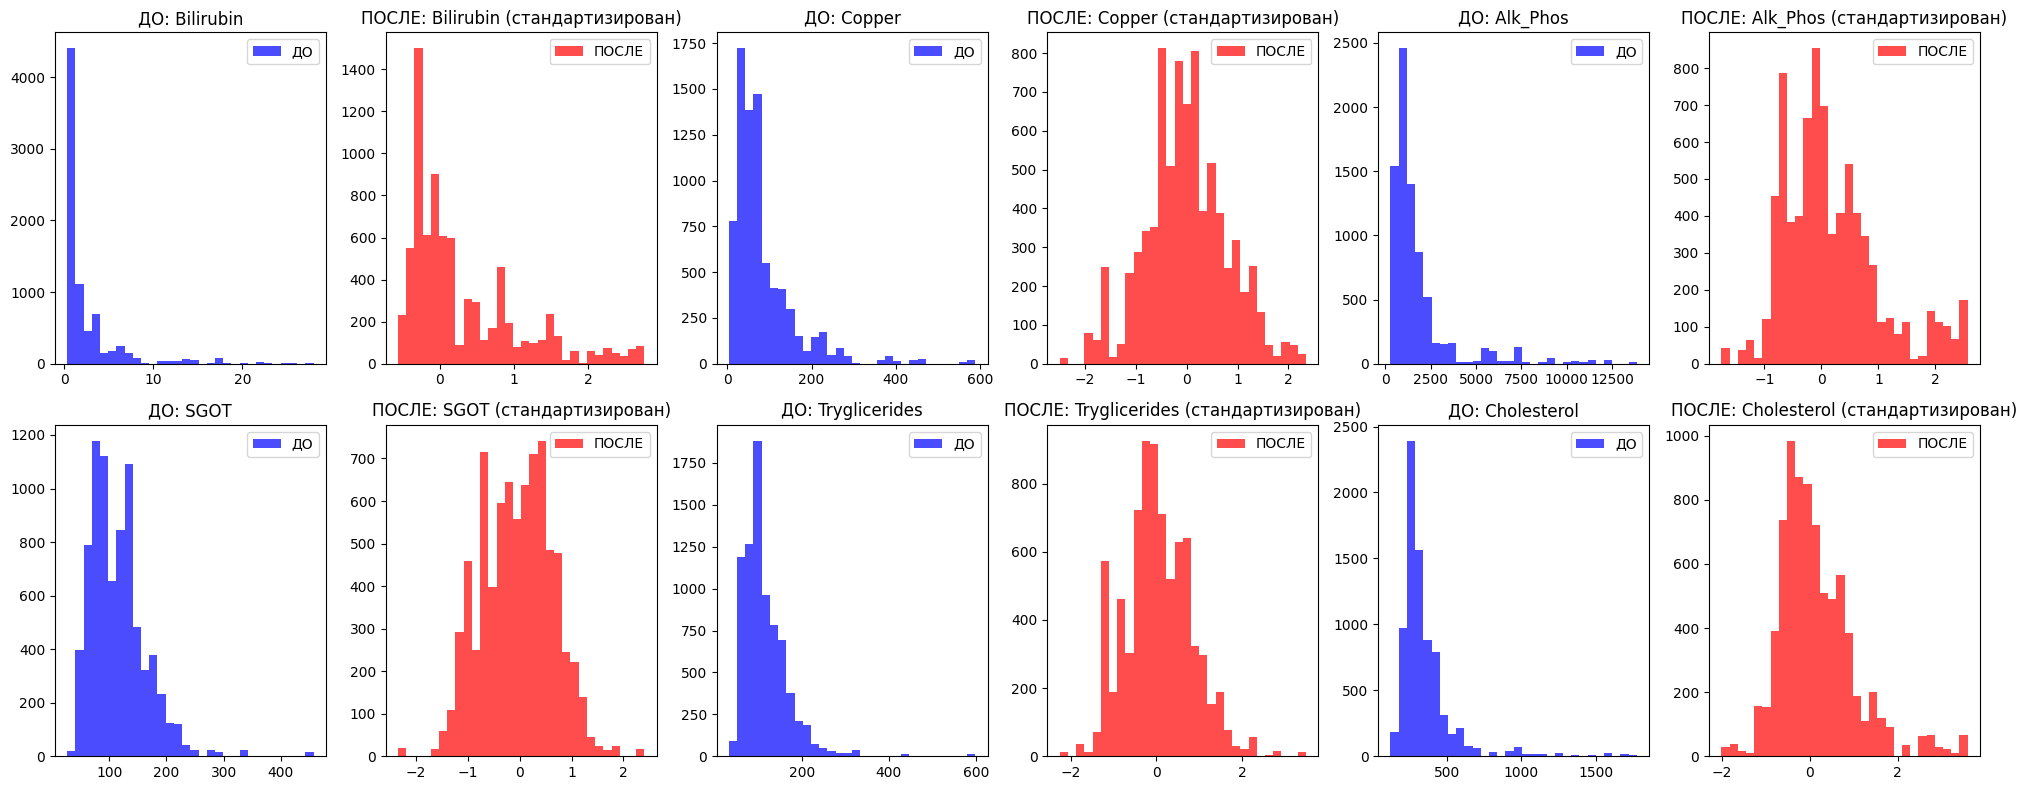

In [109]:
def compare_skewed_features(original_df, processed_df, skewed_features_list, n_cols=3):
    """
    Сравнивает распределения только skewed-признаков ДО логарифмирования
    и ПОСЛЕ всего пайплайна преобразований
    """
    # Берем только skewed features, которые есть в исходных данных
    features_to_compare = [col for col in skewed_features_list if col in original_df.columns]

    print(f"Сравниваем {len(features_to_compare)} skewed-признаков: {features_to_compare}")

    if not features_to_compare:
        print("Нет skewed-признаков для сравнения!")
        return

    n_features = len(features_to_compare)
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols*2, figsize=(20, 4*n_rows))
    axes = axes.ravel()

    for i, col in enumerate(features_to_compare):
        # ДО преобразования (исходные данные)
        axes[i*2].hist(original_df[col], bins=30, alpha=0.7, color='blue', label='ДО')
        axes[i*2].set_title(f'ДО: {col}')
        axes[i*2].legend()

        # ПОСЛЕ преобразования (стандартизированные данные)
        # Ищем соответствующий признак в processed_df
        processed_col = col  # т.к. verbose_feature_names_out=False, имена сохранились
        axes[i*2+1].hist(processed_df[processed_col], bins=30, alpha=0.7, color='red', label='ПОСЛЕ')
        axes[i*2+1].set_title(f'ПОСЛЕ: {col} (стандартизирован)')
        axes[i*2+1].legend()

    # Скрываем лишние subplots
    for j in range(n_features*2, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# Правильный вызов функции
print("=== СРАВНЕНИЕ ПРИЗНАКОВ С АСИММЕТРИЕЙ ===")
skewed_features_all = normal_skewed + problem_skewed  # объединяем обе группы
compare_skewed_features(df, processed_df, skewed_features_all)

2. Сравнение выбросов ДО/ПОСЛЕ


=== СРАВНЕНИЕ ВЫБРОСОВ ===


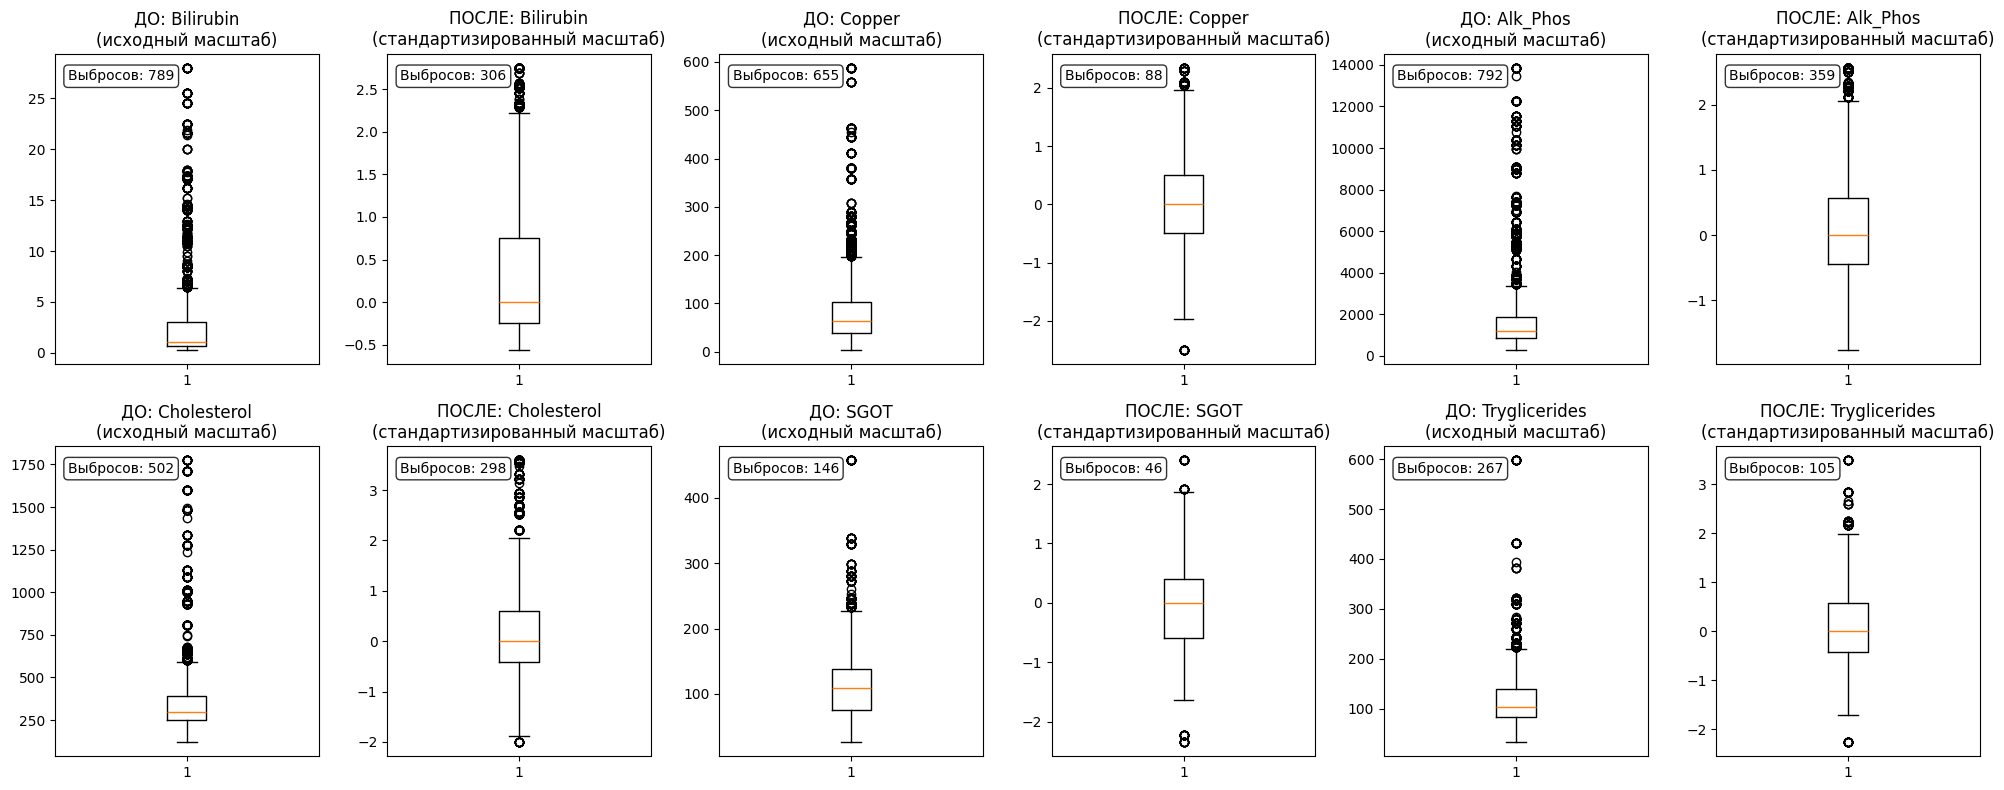

In [111]:
def compare_outliers(original_df, processed_df, numeric_features, n_cols=3):
    """
    Сравнивает выбросы ДО и ПОСЛЕ обработки и учитывает разницу в масштабах данных.
    """
    n_features = len(numeric_features)
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols*2, figsize=(20, 4*n_rows))
    axes = axes.ravel()

    for i, col in enumerate(numeric_features):
        # ДО обработки выбросов (исходный масштаб)
        axes[i*2].boxplot(original_df[col])
        axes[i*2].set_title(f'ДО: {col}\n(исходный масштаб)')

        # Добавляем статистику выбросов
        Q1 = original_df[col].quantile(0.25)
        Q3 = original_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_count = ((original_df[col] < lower_bound) | (original_df[col] > upper_bound)).sum()
        axes[i*2].text(0.05, 0.95, f'Выбросов: {outliers_count}',
                      transform=axes[i*2].transAxes, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # ПОСЛЕ обработки выбросов (стандартизированный масштаб)
        axes[i*2+1].boxplot(processed_df[col])
        axes[i*2+1].set_title(f'ПОСЛЕ: {col}\n(стандартизированный масштаб)')

        # Статистика выбросов после обработки
        Q1_p = processed_df[col].quantile(0.25)
        Q3_p = processed_df[col].quantile(0.75)
        IQR_p = Q3_p - Q1_p
        lower_bound_p = Q1_p - 1.5 * IQR_p
        upper_bound_p = Q3_p + 1.5 * IQR_p
        outliers_count_p = ((processed_df[col] < lower_bound_p) | (processed_df[col] > upper_bound_p)).sum()
        axes[i*2+1].text(0.05, 0.95, f'Выбросов: {outliers_count_p}',
                        transform=axes[i*2+1].transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    for j in range(n_features*2, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

print("=== СРАВНЕНИЕ ВЫБРОСОВ ===")
compare_outliers(df, processed_df, ['Bilirubin', 'Copper', 'Alk_Phos', 'Cholesterol', 'SGOT', 'Tryglicerides'])

Общая краткая статистика по предобработке

In [114]:
print("=== КРАТКАЯ СТАТИСТИКА ПРЕДОБРАБОТКИ ===")
print("ОБЩАЯ ИНФОРМАЦИЯ:")
print(f"   • Исходные данные: {df.shape[0]} строк, {df.shape[1]} признаков")
print(f"   • После обработки: {processed_df.shape[0]} строк, {processed_df.shape[1]} признаков")
print(f"   • Новых признаков: +{processed_df.shape[1] - df.shape[1]} (One-Hot Encoding)")

print("ОБРАБОТКА ВЫБРОСОВ (IQR Clipping):")
# Считаем общее количество выбросов до обработки
total_outliers_before = 0
for col in ['Bilirubin', 'Copper', 'Alk_Phos', 'Cholesterol', 'SGOT', 'Tryglicerides']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    total_outliers_before += outliers
    print(f"   • {col}: {outliers} выбросов")

print(f"ВСЕГО выбросов в skewed-признаках: {total_outliers_before}")

print("ПРЕОБРАЗОВАНИЯ ПРИЗНАКОВ:")
print(f"   • Числовые симметричные: {len(symmetric_features)} признаков")
print(f"   • Числовые асимметричные: {len(normal_skewed) + len(problem_skewed)} признаков")
print(f"   • Бинарные категориальные: {len(binary_features)} признаков")
print(f"   • Многоклассовые категориальные: {len(multi_category_features)} признаков")

print("МАСШТАБИРОВАНИЕ:")
print(f"   • RobustScaler применен ко всем числовым признакам")
print(f"   • Логарифмирование (log1p) для {len(normal_skewed) + len(problem_skewed)} асимметричных признаков")

print("КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ:")
print(f"   • OrdinalEncoder: {len(binary_features)} бинарных признаков")
print(f"   • OneHotEncoder: {len(multi_category_features)} → {len(multi_category_features) + 1} признаков")

print("РЕЗУЛЬТАТ:")
print(f"   • Данные готовы для ML моделей")
print(f"   • Data leakage предотвращена (train/test разделение)")
print(f"   • Выбросы обработаны, признаки масштабированы")
print(f"   • Категориальные признаки закодированы")

=== КРАТКАЯ СТАТИСТИКА ПРЕДОБРАБОТКИ ===
ОБЩАЯ ИНФОРМАЦИЯ:
   • Исходные данные: 7905 строк, 19 признаков
   • После обработки: 7905 строк, 21 признаков
   • Новых признаков: +2 (One-Hot Encoding)
ОБРАБОТКА ВЫБРОСОВ (IQR Clipping):
   • Bilirubin: 789 выбросов
   • Copper: 655 выбросов
   • Alk_Phos: 792 выбросов
   • Cholesterol: 502 выбросов
   • SGOT: 146 выбросов
   • Tryglicerides: 267 выбросов
ВСЕГО выбросов в skewed-признаках: 3151
ПРЕОБРАЗОВАНИЯ ПРИЗНАКОВ:
   • Числовые симметричные: 5 признаков
   • Числовые асимметричные: 6 признаков
   • Бинарные категориальные: 5 признаков
   • Многоклассовые категориальные: 2 признаков
МАСШТАБИРОВАНИЕ:
   • RobustScaler применен ко всем числовым признакам
   • Логарифмирование (log1p) для 6 асимметричных признаков
КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ:
   • OrdinalEncoder: 5 бинарных признаков
   • OneHotEncoder: 2 → 3 признаков
РЕЗУЛЬТАТ:
   • Данные готовы для ML моделей
   • Data leakage предотвращена (train/test разделение)
   • Выбросы обработаны, 